In [1]:
!pip install Bio
!pip install requests

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio import pairwise2
from Bio.Align import substitution_matrices
import seaborn as sns
import numpy as np
import requests
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

c:\ProgramData\anaconda3\envs\deeploc_20\lib\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [3]:
def get_kingdom(uniprot_id):
    url = f"https://www.uniprot.org/uniprot/{uniprot_id}.txt"
    response = requests.get(url)
    data = response.text
    for line in data.split("\n"):
        if line.startswith("OC"):
            return line[5:].split("; ")[1]

In [4]:
def convert_names(name):
    if(name == 'Nucleus'):
        return 'Nucleus'
    elif(name == 'Cytoplasm'):
        return 'Cytoplasm'
    elif(name == 'Extracellular'):
        return 'Extracellular'
    elif(name == 'Mitochondrion'):
        return 'Mitochondrion'
    elif(name == 'Cell.membrane'):
        return 'Cell membrane'
    elif(name == 'Endoplasmic.reticulum'):
        return 'Endoplasmic reticulum'
    elif(name == 'Plastid'):
        return 'Plastid'
    elif(name == 'Golgi.apparatus'):
        return 'Golgi apparatus'
    elif(name == 'Lysosome/Vacuole'):
        return 'Lysosome/Vacuole'
    elif(name == 'Peroxisome'):
        return 'Peroxisome'
    

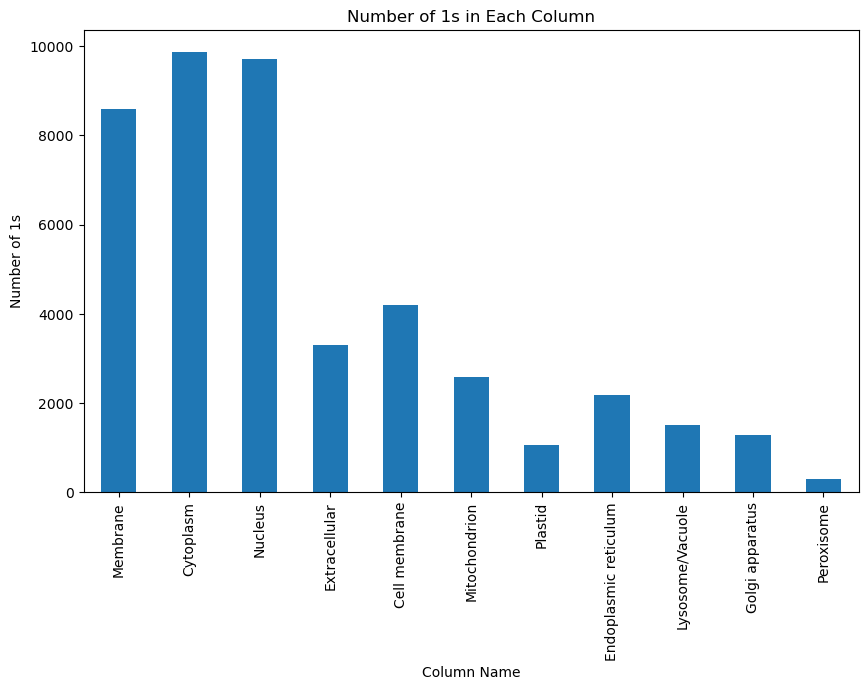

In [5]:
orginal_dataframe = pd.read_csv('data_files/multisub_5_partitions_unique.csv')
selected_columns = orginal_dataframe.loc[:, 'Membrane':'Peroxisome']
count_ones = (selected_columns == 1).sum()

plt.figure(figsize=(10,6))
count_ones.plot(kind='bar')
plt.xlabel('Column Name')
plt.ylabel('Number of 1s')
plt.title('Number of 1s in Each Column')
plt.show()

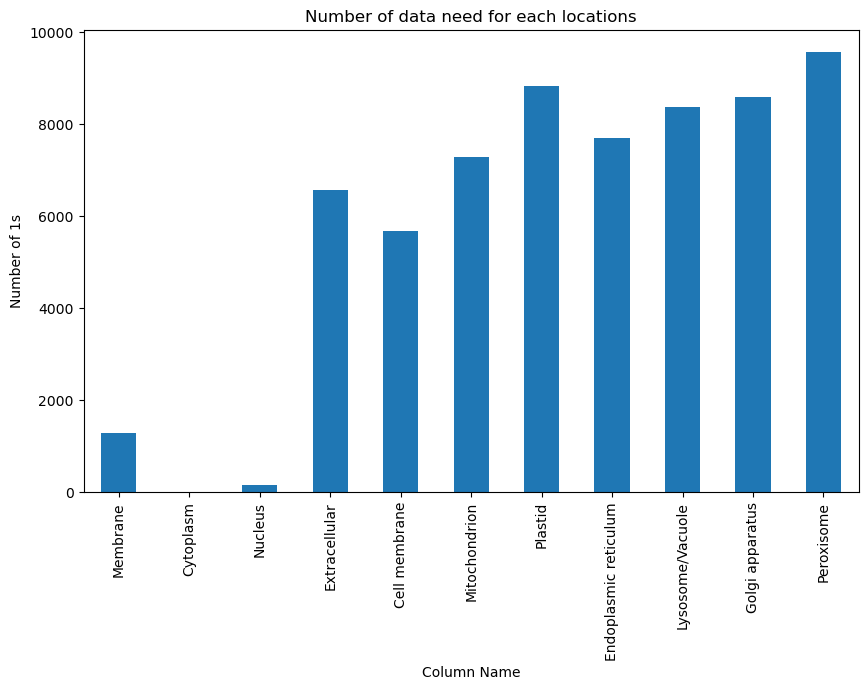

Membrane                 1277
Cytoplasm                   0
Nucleus                   150
Extracellular            6569
Cell membrane            5683
Mitochondrion            7280
Plastid                  8823
Endoplasmic reticulum    7690
Lysosome/Vacuole         8374
Golgi apparatus          8591
Peroxisome               9566
dtype: int64


In [6]:
MAX_VALUE = 9870
data_need = MAX_VALUE - count_ones
plt.figure(figsize=(10,6))
data_need.plot(kind='bar')
plt.xlabel('Column Name')
plt.ylabel('Number of 1s')
plt.title('Number of data need for each locations')
plt.show()
print(data_need)

In [7]:
# Parse the fasta file
records = list(SeqIO.parse('deeploc_data.fasta', 'fasta'))

# Extract the ID, location (second value), and sequence for each record
data = [(rec.id, convert_names(rec.description.split()[1].split('-')[0]), str(rec.seq)) for rec in records if 'test' not in rec.description]

# Create a DataFrame
deeploc_1_dataframe = pd.DataFrame(data, columns=['ACC', 'Location', 'Sequence'])


In [8]:
print(deeploc_1_dataframe.iloc[0])

ACC                                                    Q5I0E9
Location                                        Cell membrane
Sequence    MEVLEEPAPGPGGADAAERRGLRRLLLSGFQEELRALLVLAGPAFL...
Name: 0, dtype: object


In [63]:
print(orginal_dataframe.iloc[0])

Unnamed: 0                                                               0
ACC                                                                 Q28165
Kingdom                                                            Metazoa
Partition                                                                4
Membrane                                                               0.0
Cytoplasm                                                              1.0
Nucleus                                                                1.0
Extracellular                                                          0.0
Cell membrane                                                          0.0
Mitochondrion                                                          0.0
Plastid                                                                0.0
Endoplasmic reticulum                                                  0.0
Lysosome/Vacuole                                                       0.0
Golgi apparatus          

In [9]:
# Removing already exsists values
print(f"Number of rows before deletion: {len(deeploc_1_dataframe)}")

indices = deeploc_1_dataframe[deeploc_1_dataframe['ACC'].isin(orginal_dataframe['ACC'])].index

deeploc_1_dataframe.drop(indices, inplace=True)
deeploc_1_dataframe = deeploc_1_dataframe[deeploc_1_dataframe['Location'] != 'Cytoplasm']

print(f"Number of rows after deletion: {len(deeploc_1_dataframe)}")


Number of rows before deletion: 11231
Number of rows after deletion: 669


C:\Users\User\AppData\Local\Temp\ipykernel_27584\2684276812.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=location_counts.index, y=location_counts.values, palette="viridis")


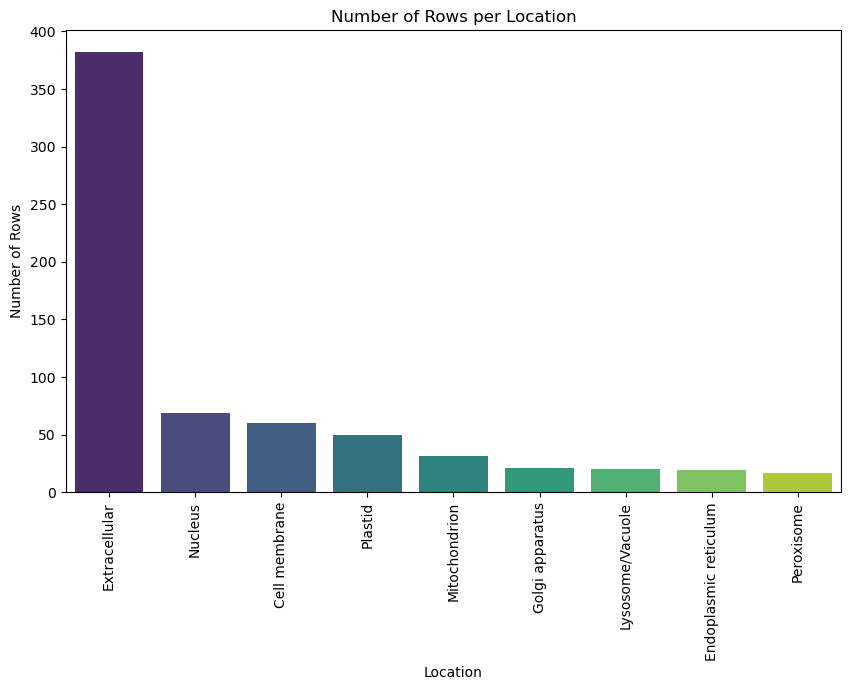

Extracellular            382
Nucleus                   69
Cell membrane             60
Plastid                   50
Mitochondrion             31
Golgi apparatus           21
Lysosome/Vacuole          20
Endoplasmic reticulum     19
Peroxisome                17
Name: Location, dtype: int64


In [10]:
location_counts = deeploc_1_dataframe['Location'].value_counts()

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=location_counts.index, y=location_counts.values, palette="viridis")
plt.xlabel('Location')
plt.ylabel('Number of Rows')
plt.title('Number of Rows per Location')
plt.xticks(rotation=90)
plt.show()
print(location_counts)

In [11]:
locations = ['Membrane', 'Cytoplasm', 'Nucleus', 'Extracellular', 'Cell membrane', 'Mitochondrion', 'Plastid', 'Endoplasmic reticulum', 'Lysosome/Vacuole', 'Golgi apparatus', 'Peroxisome']
for location in locations:
    deeploc_1_dataframe[location] = 0.0
for location in locations:
    deeploc_1_dataframe.loc[deeploc_1_dataframe['Location'] == location, location] = 1.0

deeploc_1_dataframe = deeploc_1_dataframe.drop(columns=['Location'])
deeploc_1_dataframe['Kingdom'] = deeploc_1_dataframe['ACC'].apply(get_kingdom)
num_rows = len(deeploc_1_dataframe)
num_partitions = 5
deeploc_1_dataframe['Partition'] = np.repeat(range(num_partitions), num_rows // num_partitions + 1)[:num_rows]
cols = ['Unnamed: 0', 'ACC', 'Kingdom', 'Partition'] + locations + ['Sequence']
deeploc_1_dataframe = deeploc_1_dataframe.reset_index().rename(columns={'index': 'Unnamed: 0'})[cols]


In [12]:
deeploc_1_dataframe.to_csv('filtered_deeploc1_data.csv', index=False)

Checking Similarity

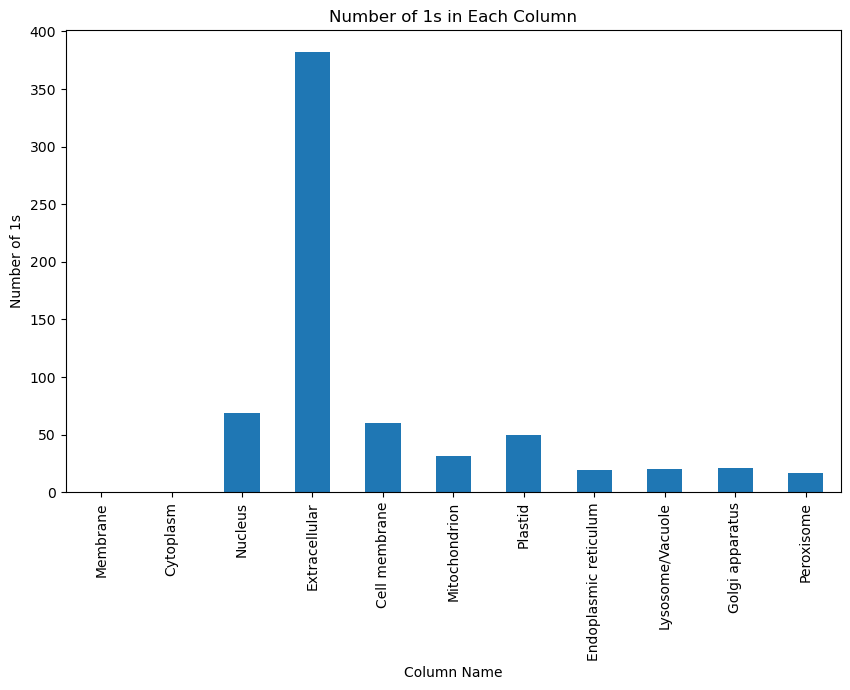

In [13]:
filtered_dataframe = pd.read_csv('filtered_deeploc1_data.csv')
selected_columns = filtered_dataframe.loc[:, 'Membrane':'Peroxisome']
count_ones = (selected_columns == 1).sum()

plt.figure(figsize=(10,6))
count_ones.plot(kind='bar')
plt.xlabel('Column Name')
plt.ylabel('Number of 1s')
plt.title('Number of 1s in Each Column')
plt.show()

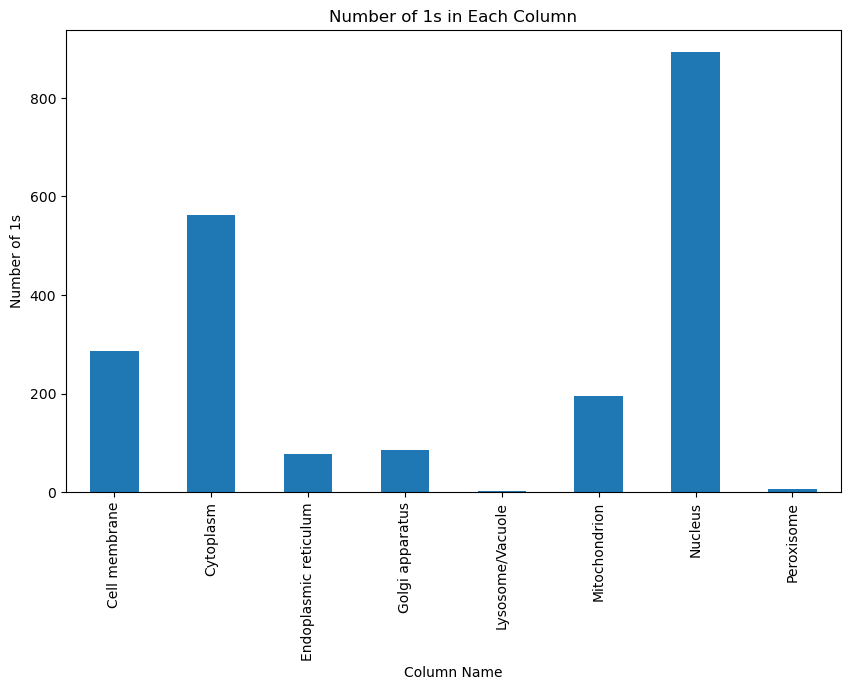

In [14]:
ind_dataframe = pd.read_csv('data_files/hpa_testset.csv')
selected_columns = ind_dataframe.loc[:, 'Cell membrane':'Peroxisome']
count_ones = (selected_columns == 1).sum()

plt.figure(figsize=(10,6))
count_ones.plot(kind='bar')
plt.xlabel('Column Name')
plt.ylabel('Number of 1s')
plt.title('Number of 1s in Each Column')
plt.show()

In [15]:
print(ind_dataframe.iloc[0])

sid                                                        ENSP00000355743
Cell membrane                                                            0
Cytoplasm                                                                0
Endoplasmic reticulum                                                    0
Golgi apparatus                                                          0
Lysosome/Vacuole                                                         0
Mitochondrion                                                            0
Nucleus                                                                  1
Peroxisome                                                               0
Lengths                                                                496
fasta                    MAAAAGPGAALSPRPCDSDPATPGAQSPKDDNEDNSNDGTQPSKRR...
Name: 0, dtype: object


In [16]:
matrix = substitution_matrices.load("BLOSUM62")

In [17]:
# def process_data(member, filtered_dataframe, ind_dataframe, matrix):
#     total_rows = filtered_dataframe.shape[0]
#     rows_per_member = total_rows // 4
#     start_index = (member - 1) * rows_per_member
#     end_index = start_index + rows_per_member if member != 4 else total_rows

#     filtered_dataframe_part = filtered_dataframe.iloc[start_index:end_index]
#     total_iterations = filtered_dataframe_part.shape[0] * ind_dataframe.shape[0]
#     progress_bar = tqdm(total=total_iterations, desc="Processing and Aligning data")
#     rows_to_remove = []

#     for new_data_index, new_data_row in filtered_dataframe_part.iterrows():
#         new_data_seq = new_data_row['Sequence']
#         best_alignment_score_1 = pairwise2.align.globalds(new_data_seq, new_data_seq, matrix, -10, -0.5)[0].score
#         for ind_index, ind_row in ind_dataframe.iterrows():
#             ind_data_seq = ind_row['fasta']
#             best_alignment_score_2 = pairwise2.align.globalds(ind_data_seq, ind_data_seq, matrix, -10, -0.5)[0].score
#             alignment_score = pairwise2.align.globalds(new_data_seq, ind_data_seq, matrix, -10, -0.5)[0].score

#             # Calculate similarity as the ratio of the alignment probability to the maximum possible alignment probability
#             similarity = alignment_score / max(best_alignment_score_1, best_alignment_score_2)
#             if(similarity > 0.3):
#                 print(f"row {new_data_index} similarity: {similarity*100}%")
#                 print(pairwise2.align.globalds(new_data_seq, ind_data_seq, matrix, -10, -0.5)[0])
#                 rows_to_remove.append(new_data_index)
#             progress_bar.update()

#     progress_bar.close()  # Close the progress bar after all iterations are done
#     filtered_dataframe_part = filtered_dataframe_part.drop(rows_to_remove)
#     filtered_dataframe_part.to_csv(f'dissimilar_data_part{member}.csv', index=False)

# # Call the function with the member number
# process_data(1, filtered_dataframe, ind_dataframe, matrix)


In [18]:
def process_data_part(member, filtered_dataframe, ind_dataframe, matrix, start_index, end_index):
    filtered_dataframe_part = filtered_dataframe.iloc[start_index:end_index]
    total_iterations = filtered_dataframe_part.shape[0] * ind_dataframe.shape[0]
    progress_bar = tqdm(total=total_iterations, desc=f"Processing and Aligning data for member {member}")
    rows_to_remove = set()

    for new_data_index, new_data_row in filtered_dataframe_part.iterrows():
        new_data_seq = new_data_row['Sequence']
        best_alignment_score_1 = pairwise2.align.globalds(new_data_seq, new_data_seq, matrix, -10, -0.5)[0].score
        for ind_index, ind_row in ind_dataframe.iterrows():
            ind_data_seq = ind_row['fasta']
            best_alignment_score_2 = pairwise2.align.globalds(ind_data_seq, ind_data_seq, matrix, -10, -0.5)[0].score
            alignment_score = pairwise2.align.globalds(new_data_seq, ind_data_seq, matrix, -10, -0.5)[0].score

            # Calculate similarity as the ratio of the alignment probability to the maximum possible alignment probability
            similarity = alignment_score / max(best_alignment_score_1, best_alignment_score_2)
            if(similarity > 0.3):
                print(f"row {new_data_index} similarity: {similarity*100}%")
                print(pairwise2.align.globalds(new_data_seq, ind_data_seq, matrix, -10, -0.5)[0])
                rows_to_remove.add(new_data_index)
            progress_bar.update()

    progress_bar.close()  # Close the progress bar after all iterations are done
    filtered_dataframe_part = filtered_dataframe_part.drop(list(rows_to_remove))
    filtered_dataframe_part.to_csv(f'dissimilar_data_part{member}.csv', index=False)

def process_data(filtered_dataframe, ind_dataframe, matrix,Member):
    Member = (Member-1)*4 + 1
    total_rows = filtered_dataframe.shape[0]
    rows_per_member = total_rows // 16
    indices = [(member, (member - 1) * rows_per_member, member * rows_per_member if member != 16 else total_rows) for member in range(Member, Member+4)]

    with ThreadPoolExecutor() as executor:
        executor.map(lambda x: process_data_part(x[0], filtered_dataframe, ind_dataframe, matrix, x[1], x[2]), indices)

# Call the function
process_data(filtered_dataframe, ind_dataframe, matrix,2)  #replace 1 with correct number - sahan 2


Processing and Aligning data for member 6:   0%|          | 0/70397 [00:00<?, ?it/s]

Processing and Aligning data for member 6:   0%|          | 1/70397 [00:00<6:48:29,  2.87it/s]

Processing and Aligning data for member 6:   0%|          | 2/70397 [00:01<11:21:23,  1.72it/s]

Processing and Aligning data for member 6:   0%|          | 3/70397 [00:02<13:25:54,  1.46it/s]


Processing and Aligning data for member 6:   0%|          | 4/70397 [00:02<10:46:24,  1.81it/s]


Processing and Aligning data for member 6:   0%|          | 5/70397 [00:03<10:16:14,  1.90it/s]

Processing and Aligning data for member 6:   0%|          | 6/70397 [00:03<11:04:06,  1.77it/s]

Processing and Aligning data for member 6:   0%|          | 7/70397 [00:03<10:26:46,  1.87it/s]


Processing and Aligning data for member 6:   0%|          | 8/70397 [00:04<7:44:51,  2.52it/s] 


Processing and Aligning data for member 6:   0%|          | 9/70397 [00:04<9:16:00,  2.11it/s]


Processing and Aligning data for memb

row 165 similarity: 33.41595313204146%
Alignment(seqA='MGFGKKKVSYFYDEDVGN-----YHYGPQHPMK-------PHRVRMVHNLVVNYNLYEKLNVITPVRATRNDMTRCHTDEYIEFLWRVTPDTMEKFQPHQLKFNVGDDCPVFDGLYEFCSISAGGSIGAAQELNSGNAEIAINWAGGLHHAKKREASGFCYVNDIALAALELLKYHQRVLYIDIDVHHGDGVEEFFYTTDRVMTCSFHKFGE-YFPGTGHIKDTGIGTGKNYAVNVPLRDGIDDESYESVFKPVISHIMQWFRPEAVILQCGTDSLAGDRLGCFNLSMKGHSMCVDFVKSFNLPMICVGGGGYTVRNVARVWTYETGLLAGEELDENLPYNDYLQYYGPDYKLNVLSNNMENHNTRQYLDSITSEIIENLRNLSFAPSVQMHKTPGDFTFENAEKQNI---AKEEIMDERV', seqB='MEEPEEPA------DSGQSLVPVYIYSPEYVSMCDSLAKIPKRASMVHSLIEAYALHKQMRIVKPKVASMEEMATFHTDAYLQHLQKVSQEG-DDDHPDSIEYGLGYDCPATEGIFDYAAAIGGATITAAQCLIDGMCKVAINWSGGWHHAKKDEASGFCYLNDAVLGILRLRRKFERILYVDLDLHHGDGVEDAFSFTSKVMTVSLHKFSPGFFPGTGDVSDVGLGKGRYYSVNVPIQDGIQDEKYYQICESVLKEVYQAFNPKAVVLQLGADTIAGDPMCSFNMTPVGIGKCLKYILQWQLATLILGGGGYNLANTARCWTYLTGVILGKTLSSEIPDHEFFTAYGPDYVLEITPSCRPDRNEPHRIQQILNYIKEKWPVGFGAQCFYLGKCGKAKTTEGQSEQLFIPRAQSGNLKHVV', score=741.5, start=0, end=421)


Processing and Aligning data for member 7:   2%|▏         | 1512/70397 [42:49<17:21:33,  1.10it/s]

Processing and Aligning data for member 6:   4%|▍         | 3104/70397 [42:49<8:12:11,  2.28it/s]


Processing and Aligning data for member 6:   4%|▍         | 3105/70397 [42:50<7:09:00,  2.61it/s]


Processing and Aligning data for member 6:   4%|▍         | 3106/70397 [42:50<6:22:59,  2.93it/s]

Processing and Aligning data for member 6:   4%|▍         | 3107/70397 [42:51<9:59:13,  1.87it/s]


Processing and Aligning data for member 6:   4%|▍         | 3108/70397 [42:52<8:46:46,  2.13it/s]

Processing and Aligning data for member 6:   4%|▍         | 3109/70397 [42:52<11:53:18,  1.57it/s]

Processing and Aligning data for member 6:   4%|▍         | 3110/70397 [42:53<13:06:54,  1.43it/s]

Processing and Aligning data for member 6:   4%|▍         | 3111/70397 [42:54<14:15:41,  1.31it/s]

Processing and Aligning data for member 6:   4%|▍         | 3112/70397 [42:55<13:40:06,  1.37it/s]

Pr

In [ ]:
# files = [f'dissimilar_data_part{i}.csv' for i in range(1, 5)]

# dataframes = [pd.read_csv(file) for file in files]
# merged_dataframe = pd.concat(dataframes)

# merged_dataframe.to_csv('dissimilar_data.csv', index=False)